### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [1]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
# Defining important metrics and functions

# Setting NSIDE valuesfrom sklearn.model_selection import train_test_split
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))


def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg
Approximate resolution at NSIDE 256 is 0.052 deg


### 1. Get a catalogue of all objects in the Galaxy Survey



In [3]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_north.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,541202,140.895285,39.405974,0,0,1
1,541202,140.895584,39.576038,0,0,1
2,541202,140.895693,39.403449,0,0,1
3,541202,140.896081,39.479529,0,0,1
4,541202,140.896304,39.621573,0,1,0


In [4]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_south.head()


,BrickID,RA,DEC,LRG,ELG,QSO
0,387694,350.870568,9.868695,1,0,0
1,387694,350.871680,9.637755,0,1,0
2,387694,350.872142,9.694869,0,0,1
3,387694,350.872631,9.724626,0,0,1
4,387694,350.873243,9.683394,0,1,0


In [5]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

89085
235166
324251


In [6]:
df = pd.concat((df_south, df_north), axis=0)

In [7]:
print(len(df))

114231322


In [8]:
print(df.shape)
duplicates_removed = df.drop_duplicates()

print(duplicates_removed.shape)

(114231322, 6)
(114196999, 6)


In [9]:
df = duplicates_removed

print(len(df.BrickID.unique()))

313749


In [10]:
print(df.isna().sum())

BrickID         0
RA         138378
DEC        138378
LRG             0
ELG             0
QSO             0
dtype: int64


In [11]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

307709
114058621


### 2. Get Galaxy Count per Healpy Pixel


In [12]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 12704437
[  1558   1560   1561 ... 757955 758427 758428]
Mean LRGs per Pixel: 33.70637146306196


,pixel_id,lrg
0,1558,2
1,1560,1
2,1561,3
3,1562,1
4,1564,2


In [13]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 47445048
[  1558   1559   1560 ... 758428 758429 758430]
Mean ELGs per Pixel: 125.38530737802397
[[  1558      6]
 [  1559      3]
 [  1560      7]
 ...
 [758428     12]
 [758429      4]
 [758430      6]]
   pixel_id  elg
0      1558    6
1      1559    3
2      1560    7
3      1561    4
4      1562    5


In [14]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 59354873
[  1558   1559   1560 ... 758428 758429 758430]
Mean QSOs per Pixel: 156.79491798991418
[[  1558      9]
 [  1559      5]
 [  1560      8]
 ...
 [758428      6]
 [758429      6]
 [758430      4]]
   pixel_id  qso
0      1558    9
1      1559    5
2      1560    8
3      1561    6
4      1562    6


In [15]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id       0
lrg         1928
elg          449
qso          292
dtype: int64
(376915, 2) (378394, 2) (378551, 2) (378843, 4)


In [16]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print(df.shape)

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64
(376703, 4)


### 3. Plotting Galaxy Densities

0.0 180.0 -180.0 180.0


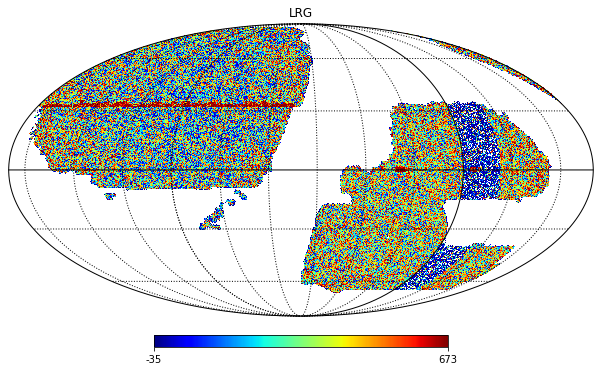

In [238]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


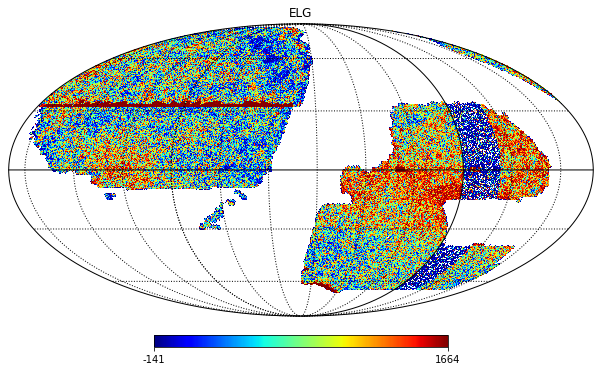

In [239]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


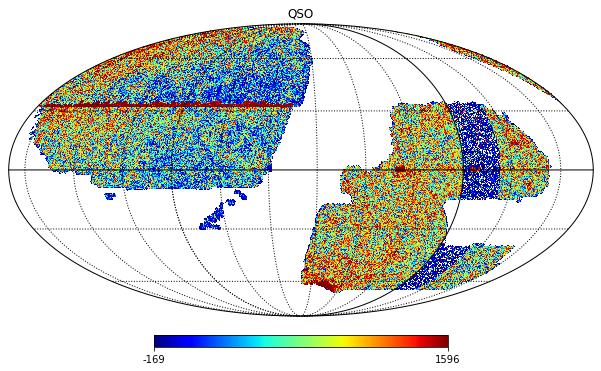

In [240]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [17]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [18]:
df = df.astype(int)
df.head()



,pixel_id,lrg,elg,qso
0,1558,2,6,9
1,1560,1,7,8
2,1561,3,4,6
3,1562,1,5,6
4,1564,2,4,10


In [19]:
pix_ids = df.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df['exposures'] = exp_len

df.head()

[  1558   1560   1561 ... 757955 758427 758428]
[10. 11. 10. ...  8.  6.  9.]


,pixel_id,lrg,elg,qso,exposures
0,1558,2,6,9,10.0
1,1560,1,7,8,11.0
2,1561,3,4,6,10.0
3,1562,1,5,6,10.0
4,1564,2,4,10,10.0


In [20]:
df = df.astype(int)


0.0 180.0 -180.0 180.0


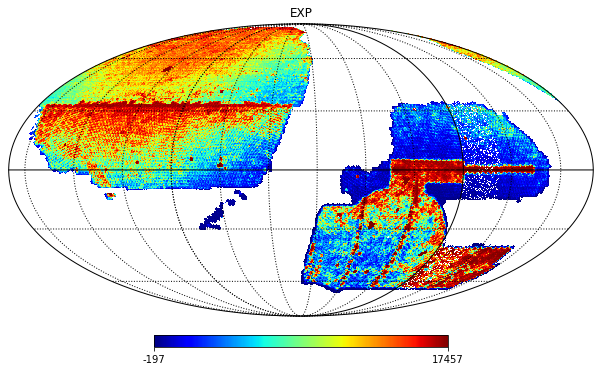

In [21]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [22]:
df_stellar_north = pd.read_csv('../../bricks_data/stellar_catalogue_north.csv')


In [23]:
df_stellar_south = pd.read_csv('../../bricks_data/stellar_catalogue_south.csv')

In [24]:
df_stellar_north.head()

,RA,DEC,GMAG,RMAG,ZMAG
0,140.898014,39.467598,18.104998,17.247044,16.888790
1,140.931050,39.523490,18.810522,17.796021,17.333416
2,140.957915,39.428128,19.376871,17.902054,16.362108
3,140.972733,39.467930,19.390877,17.886087,16.718546
4,140.981984,39.563177,18.225065,17.742722,17.618404


In [25]:
print(len(df_stellar_north) + len(df_stellar_south))

12984483


In [26]:
df_stellar = pd.concat((df_stellar_south, df_stellar_north), axis=0)


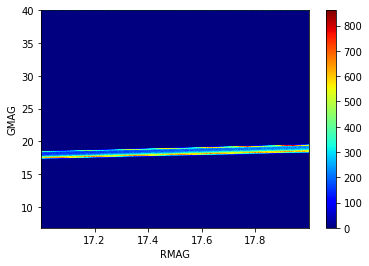

In [27]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [28]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(12984483, 5)


In [29]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [30]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4)]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4)]
print(df_stellar.shape)


(12370682, 7)


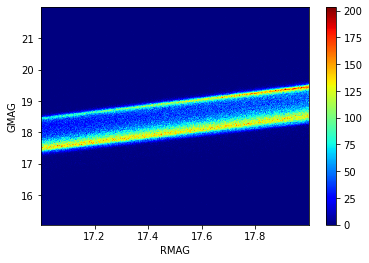

In [31]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [32]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=10000, labels=False)
df_stellar['percent_RMAG'].value_counts()


9572    1287
7633    1282
8743    1280
5324    1279
9443    1276
        ... 
8614    1194
7634    1194
5102    1193
8618    1193
4726    1192
Name: percent_RMAG, Length: 10000, dtype: int64

In [33]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [34]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=10000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=10000, labels=False)
df_stellar.shape

(12370682, 12)

In [35]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [36]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [37]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(12370682, 12)
(12272322, 12)


(12213080, 12)

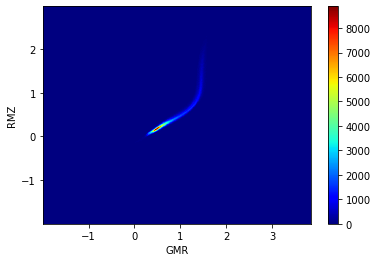

In [38]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [39]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 12213080
[  1560   1561   1562 ... 757955 758426 758427]
Mean stellars per Pixel: 32.41048231937902
[[  1560      1]
 [  1561      3]
 [  1562      2]
 ...
 [757955      4]
 [758426      2]
 [758427      2]]
   pixel_id  stellar
0      1560        1
1      1561        3
2      1562        2
3      1564        1
4      1565        3
pixel_id    0
stellar     0
dtype: int64


In [40]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id     0
lrg          0
elg          0
qso          0
exposures    0
stellar      0
dtype: int64


(375753, 6)

In [41]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar
0,1560,1,7,8,11,1
1,1561,3,4,6,10,3
2,1562,1,5,6,10,2
3,1564,2,4,10,10,1
4,1565,2,11,7,9,3


0.0 180.0 -180.0 180.0


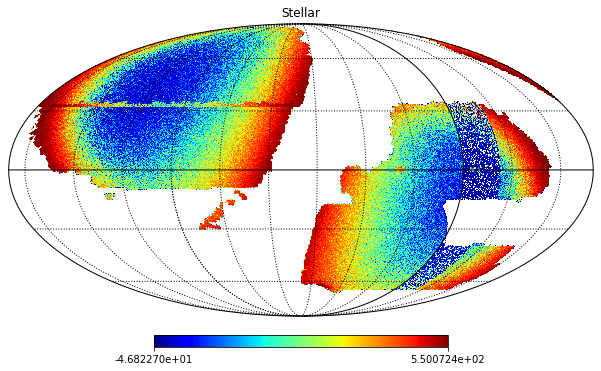

In [42]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df.pixel_id.to_numpy()] = df.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0),
            badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

#### EBV Extraction

In [43]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [44]:
from dustmaps.config import config

config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [45]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE, pixels_ids, lonlat=True)
ra_ebv = subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1560   1561   1562 ... 757954 757955 758427]


In [46]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [47]:
df.EBV.describe()
df.head()


,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1564,2,4,10,10,1,0.208612
4,1565,2,11,7,9,3,0.247232


0.0 180.0 -180.0 180.0


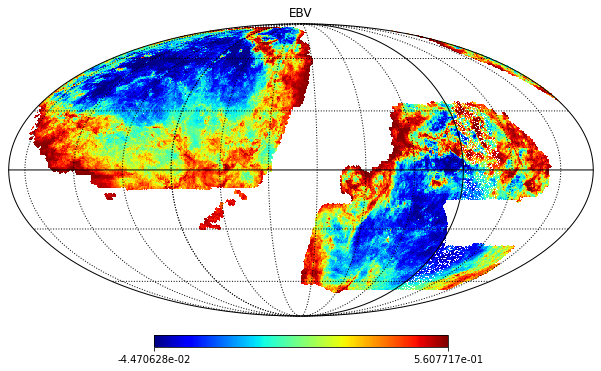

In [48]:
m_EBV = np.zeros(NPIX)

m_EBV[df.pixel_id.to_numpy()] = df.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [49]:
df.exposures = df.exposures.astype(int)
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1564,2,4,10,10,1,0.208612
4,1565,2,11,7,9,3,0.247232


In [50]:
df.to_csv('../../bricks_data/dataset_galdense.csv', index=False)



In [ ]:
df = pd.read_csv('../../bricks_data/dataset_galdense.csv',
                 dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                        'EBV': 'float'})

#### Geometric Systematics Values, not involving edge pixels

In [51]:
with open('../../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geo_dict = pickle.load(f)
    f.close()

print(len(geo_dict.keys()))

446042


In [53]:
sys_list = []
for key in geo_dict.keys():
    ind_sys_list = geo_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
                                                'ccdskysb_g',
                                                'ccdskysb_r',
                                                'ccdskysb_z',
                                                'exptime_g',
                                                'exptime_r',
                                                'exptime_z',
                                                'meansky_g',
                                                'meansky_r',
                                                'meansky_z',
                                                'galdepth_g',
                                                'galdepth_r',
                                                'galdepth_z',
                                                'seeing_g',
                                                'seeing_r',
                                                'seeing_z',
                                                'mjd_obs_g',
                                                'mjd_obs_r',
                                                'mjd_obs_z', 'pixel_id'])



In [54]:
print(len((df_sys_geo_no)))

446042


In [55]:
df_geo = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(len(df))
print(len(df_geo))

375753
374163


In [56]:
print(df_geo.isna().sum())

pixel_id       0
lrg            0
elg            0
qso            0
exposures      0
stellar        0
EBV            0
airmass        0
ccdskysb_g    52
ccdskysb_r    33
ccdskysb_z     4
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
seeing_g       0
seeing_r       0
seeing_z       0
mjd_obs_g      0
mjd_obs_r      0
mjd_obs_z      0
dtype: int64


In [57]:
df_geo.dropna(axis=0, inplace=True)
print(df_geo.isna().sum())

pixel_id      0
lrg           0
elg           0
qso           0
exposures     0
stellar       0
EBV           0
airmass       0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
seeing_g      0
seeing_r      0
seeing_z      0
mjd_obs_g     0
mjd_obs_r     0
mjd_obs_z     0
dtype: int64


In [58]:
print(df_geo.describe())

            pixel_id            lrg            elg            qso  \
count  374081.000000  374081.000000  374081.000000  374081.000000   
mean   335879.684464      33.893090     126.499050     158.318517   
std    204661.969581      14.811635      35.952234      42.913133   
min      1667.000000       1.000000       1.000000       1.000000   
25%    174923.000000      26.000000     112.000000     140.000000   
50%    316798.000000      32.000000     126.000000     158.000000   
75%    461885.000000      40.000000     141.000000     177.000000   
max    757954.000000     708.000000    2936.000000    2040.000000   

           exposures        stellar            EBV        airmass  \
count  374081.000000  374081.000000  374081.000000  374081.000000   
mean       99.851468      32.524296       0.041965       1.354568   
std       248.283036      29.823615       0.032645       0.253804   
min         5.000000       1.000000       0.000583       1.000179   
25%        46.000000      15.0000

In [59]:
df_geo.to_csv('../../bricks_data/dataset_geometric.csv', index=False)


#### Plotting All Densities and systematics together


In [258]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')

In [259]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]

    m = np.zeros(NPIX)

    m[df_geo.pixel_id.to_numpy()] = df_geo[elem].to_numpy()
    mask = (m == 0)
    m[mask] = np.nan
    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1),format='%e', norm='hist', cmap="jet", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
    hp.graticule()
    i += 1

plt.show()


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/matplotlib/transforms.py:2525: RuntimeWarning: invalid value encountered in double_scalars
  y_scale = outh / inh
posx and posy should be finite values
0.0 180.0 -180.0 180.0
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.

ValueError: cannot convert float NaN to integer

### 5. Outlier Removal

In [72]:
df_geo = pd.read_csv('../../bricks_data/dataset_geometric.csv',
                     dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32',
                            'EBV': 'float'})

df_geo.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,meansky_z,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z
count,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,...,3.740810e+05,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000,374081.000000
mean,335879.684464,33.893090,126.499050,158.318517,99.851468,32.524296,0.041965,1.354568,23.464107,22.586330,...,7.945123e+08,23.670193,23.155886,22.227776,1.226926,1.104323,1.101264,57796.199178,57786.100800,57682.922776
std,204661.969581,14.811635,35.952234,42.913133,248.283036,29.823615,0.032645,0.253804,0.181661,0.226585,...,3.247259e+09,0.300798,0.335647,0.264188,0.490218,0.323395,0.364198,355.803429,351.164886,305.247682
min,1667.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.000583,1.000179,18.267529,18.225866,...,0.000000e+00,18.361883,15.734725,0.000000,0.573780,0.542340,0.000000,56536.000831,56536.081054,0.000000
25%,174923.000000,26.000000,112.000000,140.000000,46.000000,15.000000,0.019672,1.182383,23.383575,22.475316,...,2.054508e+00,23.504147,22.937472,22.166405,1.090823,0.985631,0.992643,57529.373167,57512.511980,57476.826782
50%,316798.000000,32.000000,126.000000,158.000000,69.000000,22.000000,0.032663,1.272115,23.487419,22.610264,...,2.519444e+00,23.729205,23.227402,22.286621,1.240228,1.121869,1.078466,57799.997647,57778.782716,57653.622419
75%,461885.000000,40.000000,141.000000,177.000000,134.000000,39.000000,0.053354,1.487145,23.573207,22.726593,...,3.329272e+00,23.872901,23.357121,22.378270,1.353739,1.217547,1.179873,58067.302784,58059.257525,57878.122176
max,757954.000000,708.000000,2936.000000,2040.000000,17612.000000,1911.000000,0.854514,2.385126,24.377570,25.279337,...,9.433031e+10,24.705928,24.181324,27.191251,53.560776,32.342494,58.909491,58662.327740,58661.994609,58679.138231


In [73]:
zscore = lambda x: abs((x - x.median()) / x.std())
col = list(df_geo.columns)
df_no_outlier = df_geo


#### Removing All Outliers


In [74]:
df_no_outlier = df_geo
factor = 4
print(len(df_geo))
for elem in col:
    if elem == 'stellar':
        factor = 7
    df_no_outlier['Z'] = df_no_outlier[elem].transform(zscore)
    print("Element: ", elem, "| No of Elems with Z higher than factor  : ", len(df_no_outlier[(df_no_outlier['Z'] > factor)]))
    df_no_outlier = df_no_outlier[(df_no_outlier['Z'] < factor)]

print()
print(f"Galaxies Remaining before outlier removal: {len(df_geo)}")
print(f"Galaxies Remaining after outlier removal: {len(df_no_outlier)}")
print(f"Elements cut by outlier removal: {len(df_geo) - len(df_no_outlier)}")

374081
Element:  pixel_id | No of Elems with Z higher than factor  :  0
Element:  lrg | No of Elems with Z higher than factor  :  2369
Element:  elg | No of Elems with Z higher than factor  :  2216
Element:  qso | No of Elems with Z higher than factor  :  1840
Element:  exposures | No of Elems with Z higher than factor  :  656
Element:  stellar | No of Elems with Z higher than factor  :  107
Element:  EBV | No of Elems with Z higher than factor  :  314
Element:  airmass | No of Elems with Z higher than factor  :  0
Element:  ccdskysb_g | No of Elems with Z higher than factor  :  726
Element:  ccdskysb_r | No of Elems with Z higher than factor  :  352
Element:  ccdskysb_z | No of Elems with Z higher than factor  :  1
Element:  exptime_g | No of Elems with Z higher than factor  :  0
Element:  exptime_r | No of Elems with Z higher than factor  :  0
Element:  exptime_z | No of Elems with Z higher than factor  :  0
Element:  meansky_g | No of Elems with Z higher than factor  :  613
Element:

In [75]:
#df_no_outlier = df_geo

df_no_outlier.describe()
print(df_no_outlier.shape)
print(df_no_outlier.exposures.max())

df_no_outlier = df_no_outlier[df_no_outlier.exposures < 500]
print(df_no_outlier.shape)

df_no_outlier.exposures.max()


(361797, 27)
1039
(361712, 27)


498

### Scaling the Data

In [76]:
scaler = MinMaxScaler()
#scaler = RobustScaler()

df_scaled = df_no_outlier

cololo = list(df_scaled.columns)
cololo.remove('pixel_id')

df_scaled[cololo] = scaler.fit_transform(df_no_outlier[cololo])

df_scaled.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,...,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000,361712.000000
mean,334197.809299,0.357378,0.466860,0.495685,0.173388,0.138190,0.158300,0.255751,0.575513,0.557610,...,0.649134,0.681251,0.638160,0.257462,0.243313,0.172346,0.593317,0.590410,0.532405,0.208446
std,203227.099335,0.130238,0.108868,0.117685,0.125237,0.127733,0.121341,0.183441,0.071085,0.076778,...,0.094085,0.098548,0.092441,0.081888,0.081993,0.053500,0.166541,0.164762,0.135781,0.161297
min,1667.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,172304.750000,0.277778,0.417293,0.439597,0.083164,0.062500,0.073343,0.132190,0.535978,0.516237,...,0.590595,0.611693,0.613009,0.205938,0.192289,0.135250,0.469267,0.461980,0.436145,0.081434
50%,316436.500000,0.344444,0.469925,0.500000,0.127789,0.093750,0.123227,0.196158,0.584038,0.565268,...,0.667887,0.701930,0.658365,0.266867,0.252943,0.165963,0.594326,0.586154,0.518084,0.171675
75%,458370.250000,0.422222,0.526316,0.560403,0.243408,0.165179,0.202929,0.348851,0.624114,0.607314,...,0.715769,0.741937,0.693065,0.312333,0.294745,0.202197,0.720443,0.718697,0.623125,0.302836
max,757954.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Separating train, test and validation sets

In [77]:
df_train, df_val = train_test_split(df_scaled, test_size=0.4, random_state=666, shuffle=True)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=666, shuffle=True)

total = len(df_train) + len(df_test) + len(df_val)

print(len(df_train)/total)
print(len(df_val)/total)
print(len(df_test)/total)

0.5999994470739152
0.19999889414783031
0.20000165877825452


In [78]:
df_train.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,...,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,217027.000000,2.170270e+05
mean,334131.894045,0.357292,0.466797,0.495674,0.173403,0.138451,0.158238,0.255782,0.575412,0.557588,...,0.649082,0.681395,0.638121,0.257406,0.243339,0.172276,0.593314,0.590507,0.532547,2.086416e-01
std,203145.174343,0.130211,0.108703,0.117437,0.125144,0.127751,0.121165,0.183311,0.071283,0.076787,...,0.094161,0.098541,0.092316,0.081846,0.081903,0.053389,0.166616,0.164809,0.135801,1.611533e-01
min,1667.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002690,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006866,0.000046,0.000591,0.005168,0.000000,8.386823e-07
25%,172508.000000,0.277778,0.417293,0.439597,0.083164,0.062500,0.073423,0.132493,0.535956,0.516249,...,0.590461,0.611801,0.612940,0.205977,0.192421,0.135249,0.469194,0.462015,0.436184,8.153672e-02
50%,316800.000000,0.344444,0.469925,0.500000,0.127789,0.093750,0.123305,0.196523,0.584000,0.565228,...,0.667862,0.701980,0.658312,0.266747,0.253013,0.165899,0.594337,0.586491,0.518459,1.718327e-01
75%,458284.000000,0.422222,0.526316,0.560403,0.241379,0.165179,0.202827,0.348607,0.624173,0.607272,...,0.715712,0.742042,0.693022,0.312236,0.294809,0.202224,0.720638,0.718811,0.623455,3.033006e-01
max,757954.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.915391,1.000000,...,1.000000,1.000000,0.957591,0.991564,1.000000,0.991666,1.000000,0.999993,1.000000,1.000000e+00


In [79]:
df_val.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,...,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000,72342.000000
mean,333240.795582,0.357829,0.467208,0.496110,0.173118,0.137316,0.158359,0.255878,0.575268,0.557507,...,0.648937,0.680962,0.638261,0.257196,0.243070,0.172535,0.594044,0.591067,0.532785,0.207682
std,203289.274541,0.130802,0.109358,0.118480,0.125334,0.127190,0.122212,0.183525,0.070918,0.077010,...,0.094319,0.098856,0.092726,0.082014,0.082153,0.053743,0.166321,0.164448,0.135460,0.161403
min,1672.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000261,0.000682,0.008451,...,0.000000,0.007037,0.000196,0.006312,0.002289,0.000000,0.000000,0.000000,0.000000,0.000000
25%,170972.500000,0.277778,0.417293,0.439597,0.081136,0.062500,0.072917,0.131726,0.535416,0.516037,...,0.590394,0.611453,0.613334,0.205234,0.191493,0.135290,0.470314,0.462830,0.436551,0.080775
50%,314896.500000,0.344444,0.469925,0.500000,0.127789,0.093750,0.122915,0.195793,0.583738,0.565414,...,0.667717,0.701942,0.658428,0.266598,0.252854,0.166166,0.594622,0.586689,0.518289,0.171168
75%,457346.500000,0.433333,0.526316,0.560403,0.243408,0.160714,0.202475,0.349500,0.623720,0.607326,...,0.715456,0.741670,0.693182,0.312347,0.294545,0.202327,0.720622,0.718757,0.622854,0.301609
max,757474.000000,1.000000,1.000000,1.000000,0.979716,1.000000,0.996305,0.980654,0.841648,0.999898,...,0.995540,1.000000,0.931354,1.000000,0.914824,1.000000,0.999510,1.000000,0.999998,1.000000


In [80]:
df_test.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,galdepth_g,galdepth_r,galdepth_z,seeing_g,seeing_r,seeing_z,mjd_obs_g,mjd_obs_r,mjd_obs_z,Z
count,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,...,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,72343.000000,7.234300e+04
mean,335352.553723,0.357184,0.466700,0.495292,0.173614,0.138282,0.158429,0.255531,0.576060,0.557778,...,0.649486,0.681106,0.638173,0.257894,0.243477,0.172367,0.592602,0.589463,0.531599,2.086252e-01
std,203407.803737,0.129756,0.108871,0.117632,0.125423,0.128218,0.120993,0.183749,0.070652,0.076519,...,0.093622,0.098263,0.092531,0.081886,0.082102,0.053588,0.166536,0.164931,0.136041,1.616193e-01
min,1669.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007264,0.002084,0.000670,0.004248,...,0.015781,0.000492,0.003123,0.016832,0.000000,0.006839,0.000000,0.000000,0.000000,4.158449e-07
25%,174021.500000,0.277778,0.417293,0.439597,0.083164,0.062500,0.073576,0.131762,0.536658,0.516388,...,0.591157,0.611613,0.612953,0.206378,0.193014,0.135239,0.468409,0.461116,0.435393,8.153373e-02
50%,316601.000000,0.344444,0.469925,0.500000,0.127789,0.093750,0.123359,0.195441,0.584445,0.565229,...,0.668194,0.701783,0.658447,0.267480,0.252861,0.165957,0.593819,0.583792,0.516833,1.720638e-01
75%,460209.500000,0.422222,0.526316,0.560403,0.247465,0.165179,0.203628,0.348710,0.624360,0.607433,...,0.716168,0.741883,0.693079,0.312547,0.294757,0.201989,0.719682,0.717830,0.622283,3.028620e-01
max,757471.000000,1.000000,1.000000,1.000000,0.975659,1.000000,0.998402,0.977035,1.000000,0.937988,...,0.989260,0.985632,1.000000,0.890353,0.748062,0.879652,0.999510,0.999990,1.000000,1.000000e+00


In [81]:
df_train.to_csv('../../bricks_data/train.csv', index=False)
df_val.to_csv('../../bricks_data/val.csv', index=False)
df_test.to_csv('../../bricks_data/test.csv', index=False)


### Plotting all different types of outliers that are removed

#### a. exposures


In [ ]:
plt.hist(df_geo.exposures, range=[0, 300])
df_no_outlier = df_geo

In [ ]:
elem = 'exposures'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### b. pixel_id -> Plotting State of Current Catalogue



In [ ]:
elem = 'pixel_id'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] < 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### c. lrg


In [ ]:
elem = 'lrg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### d. elg


In [ ]:
elem = 'elg'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. qso


In [ ]:
elem = 'qso'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### e. stellar


In [ ]:
elem = 'stellar'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### f. EBV



In [ ]:
elem = 'EBV'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()

#### g. exptime_g

In [ ]:
elem = 'exptime_g'

df_no_outlier['Z'] = df_geo[elem].transform(zscore)

df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

m = np.zeros(NPIX)

m[df_outlier.pixel_id.to_numpy()] = 1
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title=elem, min=-5, max=2, cbar=False, cmap="Reds", notext=False, rot=(100, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

plt.show()


#### Plotting All combined

In [ ]:
cols = list(df_geo.columns)
cols.remove('pixel_id')
cols.remove('Z')
print(len(cols))

In [ ]:
nrows = 25
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(150,150))

#fig = plt.figure()
i = 0
for ax in ax.flatten():
    elem = cols[i]
    df_no_outlier['Z'] = df_geo[elem].transform(zscore)

    df_outlier = df_no_outlier[(df_no_outlier['Z'] > 3)]

    m = np.zeros(NPIX)

    m[df_outlier.pixel_id.to_numpy()] = 1
    mask = (m == 0)
    m[mask] = np.nan

    plt.axes(ax)
    hp.mollview(m, title=elem, fig=fig, sub=(nrows, ncols, i + 1), min=-5, max=2, cbar=False, cmap="Reds", notext=False,
                rot=(100, 0, 0), badcolor='white',
                remove_dip=True, remove_mono=True, hold=True)
    #hp.graticule()
    i += 1

plt.show()
